# Covid Explainer Introduction

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [1]:
# Load Modules
import pandas as pd
import numpy as np
from datetime import timedelta

from mdp_model import *
from mdp_states_functions import *
from mdp_testing import *

In [2]:
file = 'states_combined_data.csv'
df = pd.read_csv(file)

We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

In [3]:
n_days = 15
date_col = 'date'

# take out dates for prediction
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])
split_date = df[date_col].max() - timedelta(n_days)
df_train = df.loc[df[date_col] <= split_date]
df_train

,Unnamed: 0,state,date,cases,deaths,population,emergdec,schoolclose,gathrestrict25,gathrestrictany,...,parks,transit_stations,workplaces,residential,home_time,percentage,full_time,part_time,non_home_time,distance
0,0,Alabama,2020-01-22,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,704.0,64.0,0.835616,1.333333,341.0,9297.0
1,1,Alabama,2020-01-23,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,717.0,65.0,0.772727,1.218182,338.0,9057.0
2,2,Alabama,2020-01-24,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,663.0,63.0,0.777778,1.333333,349.0,9247.0
3,3,Alabama,2020-01-25,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,811.0,80.0,0.142857,0.533333,176.0,9830.0
4,4,Alabama,2020-01-26,0,0,4903185.0,0,0,0,0,...,NaN,NaN,NaN,NaN,910.0,85.0,0.120000,0.446809,143.0,7953.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7462,8317,Wyoming,2020-05-10,662,7,578759.0,1,1,0,1,...,53.0,-4.0,-18.0,3.0,729.0,95.0,0.055556,0.157895,34.0,1887.0
7463,8318,Wyoming,2020-05-11,669,7,578759.0,1,1,0,1,...,13.0,-2.0,-27.0,10.0,704.0,90.0,0.120000,0.260870,46.0,1780.0
7464,8319,Wyoming,2020-05-12,675,7,578759.0,1,1,0,1,...,33.0,3.0,-27.0,10.0,690.0,87.0,0.120000,0.250000,56.0,1763.0
7465,8320,Wyoming,2020-05-13,688,7,578759.0,1,1,0,1,...,47.0,4.0,-28.0,10.0,649.0,84.0,0.125000,0.294118,72.0,1778.0


## Creating Samples

Usually at this point we will set all the parameters that we use to run `model.fit`, but first I want to show you how the actual training samples are created from the data given (which usually happens within `model.fit`). 

Now this is a very important part! We need to specify a `target` value that our model aims to predict from the training data. The few other things we have to specify include `date_col`, `region_col` and `feature_cols`. `region_col` is the name of the area we are measuring, such as `'state'`, while `feature_cols` are a list of strings we want to use as features, such as `['home_time']`. 

`d_avg` is the number of days we want to average when creating each datapoint, which can help decrease noise if there is a sudden spike in cases at a certain day. 

In [4]:
# Setting parameters
target = 'cases'
region_col = 'state'
date_col = 'date'
feature_cols = ['home_time']
d_avg = 3

The other parameters relevant to creating samples include an `action_thresh`, which is a list of ints that create cutoff brackets for actions. When `action_thresh` is an empty list `[]`, the default `ACTION = 0` for all datapoints. For example (the other features will be explained below too!):

In [5]:
action_thresh = []
df_samples, pfeatures = createSamples(df, target, region_col, date_col, feature_cols, action_thresh, d_avg)
df_samples

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,TIME,cases,home_time,cases-1,cases-2,home_time-1,home_time-2,r_t,r_t-1,r_t-2,RISK,ACTION,state
0,0,2020-03-16,39.666667,747.666667,7.666667,0.000000,734.666667,734.666667,5.173913,0.000000,0.000000,1.643629,0,Alabama
1,0,2020-03-19,105.000000,666.666667,39.666667,7.666667,747.666667,734.666667,2.647059,5.173913,0.000000,0.973449,0,Alabama
2,0,2020-03-22,198.333333,795.000000,105.000000,39.666667,666.666667,747.666667,1.888889,2.647059,5.173913,0.635989,0,Alabama
3,0,2020-03-25,495.000000,801.333333,198.333333,105.000000,795.000000,666.666667,2.495798,1.888889,2.647059,0.914609,0,Alabama
4,0,2020-03-28,806.000000,914.000000,495.000000,198.333333,801.333333,795.000000,1.628283,2.495798,1.888889,0.487526,0,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,50,2020-05-15,737.000000,634.000000,688.000000,661.333333,663.000000,696.666667,1.071221,1.040323,1.038743,0.068799,0,Wyoming
1441,50,2020-05-18,776.333333,604.333333,737.000000,688.000000,634.000000,663.000000,1.053370,1.071221,1.040323,0.051994,0,Wyoming
1442,50,2020-05-21,805.666667,524.333333,776.333333,737.000000,604.333333,634.000000,1.037784,1.053370,1.071221,0.037088,0,Wyoming
1443,50,2020-05-24,843.666667,550.333333,805.666667,776.333333,524.333333,604.333333,1.047166,1.037784,1.053370,0.046087,0,Wyoming


`createSamples` has taken out some of the smaller regions with missing data, and left only the 50 states + Washington DC. It has then assigned each state to an `ID` number, and compressed the `TIME` to be one datapoint for every `n_days`. 

Next, notice that it has created a `target-1` (`cases-1` here) and `target-2` column, as well as `-1` and `-2` columns for each of the features in `feature_cols`. These are the offsets of 1 or 2 datapoints prior to the current point , respectively. At the beginning of each `ID`, when `-1` and `-2` in the features are empty, we simply substitute in the current value of the feature. 

You will also see the `r_t` rows. This is the ratio of the target value today compared to (divided by) the target value at the data point prior. `RISK` (reward) is assigned as the natural log of the `r_t` value. Note that we have also deleted the rows where `target = 0`, since this is before any of the cases have occured, and will throw an error when calculating `r_t`. 

Now, if we specify `action_thresh` to be these cutoff bins, `[-1e10, -50, 0, 50, 100, 1e10]`, these 6 numbers in the `action_thresh` delineate the start and end range of each `ACTION`, so we will be creating 5 actions total. The ranges are for the `feature_change` of the first feature in the list `feature_cols`. This `feature_change` corresponds to the `t-1` - `t-2` values of this first feature in the list. So for instance in this dataset and the above `action_thresh` with `feature_cols = ['home_time']`, `feature_cols[0] = 'home_time'`: if the `home_time_change = -75` for a certain datapoint, it will be assigned `ACTION=0` (since it is in the first bracket). 

Make sure you set `action_thresh` to encompass the entire range of possible `feature_change` values! What you choose to put as the action-determining feature (listed first in `features_cols`) and where action bin cutoffs are will of course have a big impact on how the model learns the MDP. 

In [6]:
action_thresh = [-1e10, -50, 0, 50, 100, 1e10]
df_samples, pfeatures = createSamples(df, target, region_col, date_col, feature_cols, action_thresh, d_avg)
df_samples

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,TIME,cases,home_time,cases-1,cases-2,home_time-1,home_time-2,r_t,r_t-1,r_t-2,RISK,home_time_change,ACTION,state
0,0,2020-03-16,39.666667,747.666667,7.666667,0.000000,734.666667,734.666667,5.173913,0.000000,0.000000,1.643629,0.000000,2,Alabama
1,0,2020-03-19,105.000000,666.666667,39.666667,7.666667,747.666667,734.666667,2.647059,5.173913,0.000000,0.973449,13.000000,2,Alabama
2,0,2020-03-22,198.333333,795.000000,105.000000,39.666667,666.666667,747.666667,1.888889,2.647059,5.173913,0.635989,-81.000000,0,Alabama
3,0,2020-03-25,495.000000,801.333333,198.333333,105.000000,795.000000,666.666667,2.495798,1.888889,2.647059,0.914609,128.333333,4,Alabama
4,0,2020-03-28,806.000000,914.000000,495.000000,198.333333,801.333333,795.000000,1.628283,2.495798,1.888889,0.487526,6.333333,2,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,50,2020-05-15,737.000000,634.000000,688.000000,661.333333,663.000000,696.666667,1.071221,1.040323,1.038743,0.068799,-33.666667,1,Wyoming
1441,50,2020-05-18,776.333333,604.333333,737.000000,688.000000,634.000000,663.000000,1.053370,1.071221,1.040323,0.051994,-29.000000,1,Wyoming
1442,50,2020-05-21,805.666667,524.333333,776.333333,737.000000,604.333333,634.000000,1.037784,1.053370,1.071221,0.037088,-29.666667,1,Wyoming
1443,50,2020-05-24,843.666667,550.333333,805.666667,776.333333,524.333333,604.333333,1.047166,1.037784,1.053370,0.046087,-80.000000,0,Wyoming


Finally, `pfeatures` is the number of features that are used for training, which starts at the target column and ends before the RISK column. Essentially, it is the target, features, and ratio, for the current time point as well as its history `t-1` and `t-2`. 

In [7]:
pfeatures

9

## Fitting to the Model

Now that we understand how the samples are actually created, we can fit the samples to the model! Here, there are a few additional parameters that need to be set: 

`h` is the time horizon (in number of datapoints) that we take when calculating error. Essentially, we will be calculating the error of the most recent `h` points from the end. The goal of the algorithm is to minimize `testing_error`, so `testing_error` for a sequence of `h=1` points will be much smaller than for `h=5` points. If we are doing a 2 week prediction (`n_days = 14`), `h=5` while `d_avg=3` means that 5 datapoints correspond to a 15 day timespan, which means the algorithm will be minimizing error for around a 2 week period before the last date in the training data. If we take `h=-1`, the algorithm will try to minimize error over all the datapoints available in the training data.

`n_iter` is the maximum number of clusters we want the algorithm to stop at while training. Initial clustering is done using `clustering='Agglomerative'`, with a `distance_threshold = 0.1`, based on `RISK`. The algorithm will then split the cluster that contains the most contradictions (two points in the cluster taking the same action but ending up in different clusters), so one cluster becomes two. For points in the same cluster that don't take the action causing the contradiction, the group they enter is decided by `classification = 'DecisionTreeClassifier'`, which learns which group they are closer to based on their features. Splitting will stop when `n_iter` number of total clusters is reached.

`th` is the splitting threshold, which basically allows the split to happen if the number of points in contradiction within a cluster is greater than this `th` value. 

`model.fit` will also automatically run cross validation by splitting the dataset randomly into `cv=5` combinations of testing & training, where each `ID` (state) will be in the testing set exactly once. After cross validation, it will find the number of clusters that gives the smallest `testing_error`, and split the entire dataset once more to this exact number of clusters. Now let's run it!

In [8]:
# Setting parameters
n_days = 15
date_col = 'date'
target = 'cases'
region_col = 'state'
date_col = 'date'
feature_cols = ['home_time']
d_avg = 3

h = 5
n_iter = 50
distance_threshold = 0.1
action_thresh = []
cv = 5
th = 0
classification = 'DecisionTreeClassifier'
clustering = 'Agglomerative'
n_clusters = None
random_state = 0

m = MDP_model()
m.fit(df_train, # csv file with data OR data frame
        target, # str: col name of target (i.e. 'deaths')
        region_col, # str, col name of region (i.e. 'state')
        date_col, # str, col name of time (i.e. 'date')
        feature_cols, # list of str: i.e. (['mobility', 'testing'])
        h, # time horizon
        n_iter, # max # of clusters
        d_avg, # int: number of days to average data over
        distance_threshold, # clustering diameter for Agglomerative clustering
        action_thresh, # list of cutoffs for each action bin
        cv, # number for cross validation
        th, # splitting threshold
        classification, # classification method
        clustering,# clustering method from Agglomerative, KMeans, and Birch
        n_clusters, # number of clusters for KMeans
        random_state)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
Splitting... |#Clusters:46:   0%|          | 0/4 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_select

Splitting... |#Clusters:47:  50%|█████     | 3/6 [00:06<00:06,  2.16s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/COVID/mdp_testing.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
Splitting... |#Clusters:48:  67%|██████▋   | 4/6 [00:08<00:04,  2.

Splitting... |#Clusters:42:   0%|          | 0/8 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/COVID/mdp_testing.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
Splitting... |#Clusters:43:  12%|█▎        | 1/8 [00:02<00:17,  2.45s/it]/

Splitting... |#Clusters:45:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/COVID/mdp_testing.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
Splitting... |#Clusters:46:  20%|██        | 1/5 [00:01<00:07,  1.96s/it]/

MDP Training Complete.


## Understanding Results

We have our model ready for interpretation! Let's first look at some attributes that were stored in the model after training. First, we can see how many clusters it actually ended up with at the final optimal split, as well as the training error of the lowest point of CV: 

In [10]:
print(m.opt_k)
print(m.CV_error)

49
0.09564439948982413


Now, we can run `model.predict`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [11]:
m.predict('New York', 15)

372787.87007383554

`model.predict_all` does the same thing, but for all the states for a given `n_days`. It returns a dataframe instead of just a number.

In [12]:
m.predict_all(15)

,state,TIME,cases
0,Alabama,2020-05-27,15558
1,Alaska,2020-05-27,419
2,Arizona,2020-05-27,19661
3,Arkansas,2020-05-27,6155
4,California,2020-05-27,105434
5,Colorado,2020-05-27,25395
6,Connecticut,2020-05-27,43236
7,Delaware,2020-05-27,11227
8,District of Columbia,2020-05-27,8306
9,Florida,2020-05-27,52690


We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [13]:
# Import full dataset and convert time col to time object
file = 'states_combined_data.csv'
df = pd.read_csv(file)
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = m.predict_all(n_days)
df_pred.set_index(region_col, inplace=True)
date = df_pred['TIME'].max()
df_true = df.loc[df[date_col]==date].sort_values(by=[region_col])
df_true.set_index(region_col, inplace=True)
error = mape(df_pred, df_true, m.target_col)
error

,TIME,cases,real cases,rel_error
state,,,,
Alabama,2020-05-27,15558,16032,0.029566
Alaska,2020-05-27,419,411,0.019465
Arizona,2020-05-27,19661,17318,0.135293
Arkansas,2020-05-27,6155,6277,0.019436
California,2020-05-27,105434,101050,0.043384
Colorado,2020-05-27,25395,24754,0.025895
Connecticut,2020-05-27,43236,41288,0.047181
Delaware,2020-05-27,11227,9096,0.234279
District of Columbia,2020-05-27,8306,8406,0.011896


Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

In the `mdp_testing.py` file, there are also various other visualization tools to help compare these results with real data! Most of these require you to have the original dataframe of the full data, as well as the clustered data which you can access at `model.df_trained`.

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

In [14]:
file = 'states_combined_data.csv'
df = pd.read_csv(file)

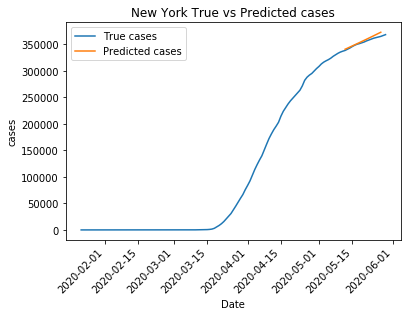

In [15]:
plot_pred(m, 'New York', df, 15)